# Cascade-LSTM Applications
## Multiclass classification
The goal of this task is to show a potential real-world application of our model. Instead of predicting the absolute value of the cascade size, a class label is predicted. The classes are 1, 1-99, 100-999,>1000

In [93]:
import os, sys

sys.path.append('../code/')

import numpy as np
import torch as th
import torch.optim as optim
from torch.utils.data import DataLoader, WeightedRandomSampler
from utils import *
from model import DeepTreeLSTMClassifier
from dataset import CascadeData
from trainer import DeepTreeTrainer
from callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns

import matplotlib
matplotlib.rcParams.update({'font.size':11,
                            'font.family':'serif'})

In [2]:
# experiment settings
x_size = 12
emo_size = 8
h_size = 8
top_size = (16, 16)

# train settings
epochs = 30
batch_size = 8
lr_tree = 0.001
lr_top = 0.001
decay_tree = 0.003
decay_top = 0.006
p_drop = 0.1

device = th.device('cpu')

data_dir = '../data/'
graphs_dir = data_dir + 'graphs_all/'
grouped_dir = data_dir + 'grouped_all/'
out_dir = '../results/classification/'
cascade_size_file = data_dir + 'cascade_size.csv'

variant = '1_hour'

In [6]:
# ---------------------------------------------
# Multi-class Classification: Cascade-LSTM
# ---------------------------------------------
train_ids = np.array([ID.split('_')[0] for ID in os.listdir(graphs_dir) if variant in ID and 'test' not in ID])
test_ids = np.unique([ID.split('_')[0] for ID in os.listdir(graphs_dir) if variant + '_test' in ID])

train_set = CascadeData(train_ids, graphs_dir, cascade_size_file, variant=variant, categorical=True)
test_set = CascadeData(test_ids, graphs_dir, cascade_size_file, test=True, variant=variant, categorical=True)

weights, weights_all = get_class_weights(train_set)
weighted_sampler = WeightedRandomSampler(weights_all, len(weights_all))

train_generator = DataLoader(train_set, collate_fn=cascade_batcher(device), batch_size=batch_size, num_workers=8, sampler=weighted_sampler)
test_generator = DataLoader(test_set, collate_fn=cascade_batcher(device), batch_size=batch_size, num_workers=8)

deep_tree = DeepTreeLSTMClassifier(x_size, 4, emo_size, h_size=h_size, top_sizes=top_size, pd=p_drop)

criterion = nn.CrossEntropyLoss()
optimizer_tree = optim.Adam(deep_tree.bottom_net.parameters(), lr = lr_tree, weight_decay = decay_tree)
optimizer_top = optim.Adam(deep_tree.top_net.parameters(), lr = lr_top, weight_decay = decay_top)
scheduler_tree = optim.lr_scheduler.StepLR(optimizer_tree, step_size=10, gamma=0.8)
scheduler_top = optim.lr_scheduler.StepLR(optimizer_top, step_size=10, gamma=0.8)


callbacks = [EarlyStopping(patience=10)]

model_trainer = DeepTreeTrainer(deep_tree)
model_trainer.compile(optimizer_tree, optimizer_top, criterion, scheduler_tree=scheduler_tree, scheduler_top=scheduler_top, callbacks=callbacks, metrics=['mul_acc'])
model_trainer.fit(train_generator, test_generator, epochs)

Epoch: 1/30
2216/2216 [########################################] - 4:15 115ms/step - loss: 0.6572 - val_loss: 0.4824 - val_mul_acc: 0.8510 
Epoch: 2/30
2216/2216 [########################################] - 4:17 116ms/step - loss: 0.4682 - val_loss: 0.4231 - val_mul_acc: 0.8648 
Epoch: 3/30
2216/2216 [########################################] - 4:04 110ms/step - loss: 0.4418 - val_loss: 0.4212 - val_mul_acc: 0.8680 
Epoch: 4/30
2216/2216 [########################################] - 3:55 106ms/step - loss: 0.4144 - val_loss: 0.4171 - val_mul_acc: 0.8668 
Epoch: 5/30
2216/2216 [########################################] - 3:50 104ms/step - loss: 0.4248 - val_loss: 0.3956 - val_mul_acc: 0.8756 
Epoch: 6/30
2216/2216 [########################################] - 3:48 103ms/step - loss: 0.4027 - val_loss: 0.4497 - val_mul_acc: 0.8531 
Epoch: 7/30
2216/2216 [########################################] - 3:51 104ms/step - loss: 0.4022 - val_loss: 0.3712 - val_mul_acc: 0.8831 
Epoch: 8/30
2216/221

In [17]:
y_pred = model_trainer.predict(test_generator)

y_true = []
ids = []
for i,_,y,_ in test_set:
    y_true.append(y)
    ids.append(i)
ids = th.tensor(ids).long().numpy()
y_true = th.tensor(y_true)

preds_cascade = pd.DataFrame({'cascade_id': ids, 'y_true':y_true, 'y_pred':y_pred})
preds_cascade.to_csv(out_dir + 'preds_cascade_lstm.csv', index=False, header=True)

In [95]:
print(classification_report(preds_cascade['y_true'], preds_cascade['y_pred']))
print(accuracy_score(preds_cascade['y_true'], preds_cascade['y_pred']))

              precision    recall  f1-score   support

           0       0.80      1.00      0.89      1108
           1       0.98      0.86      0.91      2879
           2       0.62      0.75      0.68       334
           3       0.81      0.75      0.78       110

    accuracy                           0.88      4431
   macro avg       0.80      0.84      0.82      4431
weighted avg       0.90      0.88      0.89      4431

0.8830963665086888


In [3]:
# ---------------------------------------------
# Multi-class Classification: Cascade-LSTM
# ---------------------------------------------

df_cascade_sizes = pd.read_csv(cascade_size_file)
df_train = pd.read_csv(grouped_dir + 'grouped_' + variant + '.csv')
df_test = pd.read_csv('../data/grouped_all/grouped_' + variant + '_test.csv')
df_train = df_train.sample(frac=1).reset_index(drop=True)
df_test = df_test.sample(frac=1).reset_index(drop=True)

ids = df_test['cascade_id'].values
X_train, X_test = df_train.iloc[:,1:].values, df_test.iloc[:,1:].values
y_train = pd.merge(df_train, df_cascade_sizes, on='cascade_id', how='left')['category'].values
y_test = pd.merge(df_test, df_cascade_sizes, on='cascade_id', how='left')['category'].values

classifier = RandomForestClassifier(criterion='entropy', random_state=42)
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)

preds_forest = pd.DataFrame({'cascade_id': ids, 'y_true':y_test, 'y_pred':y_pred})
preds_forest.to_csv(out_dir + 'preds_forest.csv', index=False, header=True)

In [98]:
print(classification_report(preds_forest['y_true'], preds_forest['y_pred']))
print(accuracy_score(preds_forest['y_true'], preds_forest['y_pred']))

              precision    recall  f1-score   support

           0       0.80      0.98      0.88      1108
           1       0.95      0.90      0.92      2879
           2       0.79      0.66      0.72       334
           3       0.94      0.62      0.75       110

    accuracy                           0.90      4431
   macro avg       0.87      0.79      0.82      4431
weighted avg       0.90      0.90      0.89      4431

0.8952832317761228


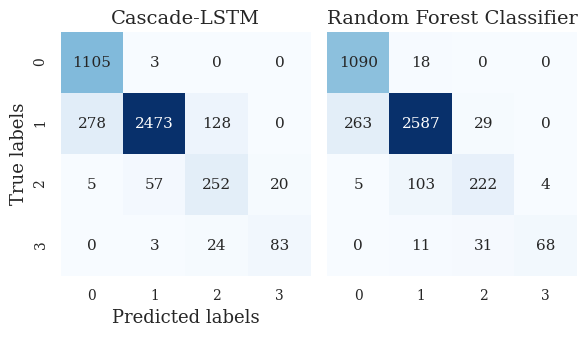

In [92]:
cm1 = confusion_matrix(preds_cascade['y_true'], preds_cascade['y_pred'])
cm2 = confusion_matrix(preds_forest['y_true'], preds_forest['y_pred'])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3.5), sharey=True)

sns.heatmap(cm1, ax=ax1, annot=True, fmt='g', cmap='Blues', cbar=False)
ax1.set_title('Cascade-LSTM', fontsize=14)
ax1.set_ylabel('True labels', fontsize=13)
ax1.set_xlabel('Predicted labels', fontsize=13)

sns.heatmap(cm2, ax=ax2, annot=True, fmt='g', cmap='Blues', cbar=False)
ax2.set_title('Random Forest Classifier', fontsize=14)

fig.tight_layout(rect=(0,0,1,1))
plt.show()
fig.savefig('../plots/confusion_matrix.pdf')